<a href="https://colab.research.google.com/github/OLaprevote/experiment-utilities/blob/main/plot_cd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CD spectra plot

This colab notebook is intended to plot circular dichroism spectra from txt files as formatted by a Jasco J-710 machine.

In [1]:
#@title Fill parameters and upload files { vertical-output: true }
import matplotlib.pyplot as plt
from pathlib import Path
import ipywidgets as widgets
try:
    from google.colab import files
    is_colab = True
except ImportError:
    is_colab = False
    #TODO
    raise Exception('This notebook is currently only supported on Google Colab.'
                    ' To port it to a local notebook one needs to replace google.colab'
                    " files upload by the ipython widget upload. Trivial, but I "
                    " didn't feel like doing then testing it.")

import numpy as np
import pandas as pd
import seaborn as sns


def df_cd(file_path: Path, df_blank=None, mw=None, resnum=None,
          mass_concentration=0.2, cell_pathlength=0.2):
    """Create dataframe from a CD txt file
    
    Parameters
    ----------
    file_path: Path
        Path of the file
    blank_df: pandas.DataFrame, optional
        DataFrame of blank buffer
    mw: float, optional
        Molecular weight in kDa (kg/mol)
    resnum: int, optional
        Number of residues of the protein
    mass_concentration: float, optional
        Massic concentration in mg/mL. Default 0.2 mg/mL
    cell_pathlength: float, optional
        Cell pathlength in cm. Default 0.2 cm.
    
    Returns
    -------
    df_tmelt: pandas.DataFrame
        DataFrame containing all CD informations
    """
    # Read file
    df_cd = pd.read_csv(file_path, sep='\s+',
                          names = ['Wavelength (nm)', 'CD (mdeg)', 'HT (V)'],
                          skiprows=19
                         )
    
    if not (df_blank is None or mw is None or resnum is None):
        mean_res_weight = mw*1000 / (resnum-1)
        
        # Mean residue molar ellipticity
        df_cd['θ_MRE (deg.cm²/dmol)'] = (
            (df_cd['CD (mdeg)'] - df_blank['CD (mdeg)']) * mean_res_weight
            / (10 * mass_concentration * cell_pathlength)
        )
     
    return df_cd


# All parameters
#@markdown **Labels** for the proteins or conditions, each label separated by a comma:
proteins = 'TrpR, TrpR WT-R1' #@param {type:"string"}

#@markdown **Molar weights** of each protein in kDa, in same order as above:
molar_weights = '12.36, 23.68' #@param {type:"string"}

#@markdown **Residue length** of each protein:
residue_lengths = '107, 204' #@param {type:"string"}

#@markdown **Temperatures** at which CD spectra were taken, separated by a comma:
temperatures = "20\xB0C, 95\xB0C, 20\xB0C \"refold\"" #@param {type:"string"}
#@markdown Click on the **play** ▶️ button on the left, then on **Choose files** bellow to upload all your files. You should then assign each file to their protein and temperature.
#@markdown 
#@markdown You can select multiple files to upload by clicking on them while pressing Ctrl.
#@markdown If you've already uploaded your files, you can click on **Cancel upload** and assign previously uploaded files.


label_list = proteins.split(', ')
mw_list = [float(mw) for mw in molar_weights.split(', ')]
reslen_list = [int(reslen) for reslen in residue_lengths.split(', ')]
temp_list = temperatures.split(', ')

# Get files
if is_colab:
    uploaded = files.upload()
    fpath_list = [fn for fn in uploaded.keys()]

if fpath_list == []:
    import glob
    fpath_list = glob.glob('*.txt')

children = ([widgets.Combobox(
            placeholder='Choose a file',
            options=fpath_list,
            description='Buffer',
            ensure_option=True,
            disabled=False)]
            + [widgets.VBox([widgets.Combobox(
            placeholder='Choose a file',
            options=fpath_list,
            description=temp,
            ensure_option=True,
            disabled=False
            ) for temp in temp_list]) for label in label_list]
)

accordion = widgets.Accordion(children=children)
for i in range(len(label_list) + 1):
    accordion.set_title(i, (['Buffer'] + label_list)[i])

display(accordion)

Saving 2022-05-13_TrpR.txt to 2022-05-13_TrpR.txt
Saving 2022-05-13_TrpR_95C.txt to 2022-05-13_TrpR_95C.txt
Saving 2022-05-13_TrpR-buffer.txt to 2022-05-13_TrpR-buffer.txt
Saving 2022-05-13_TrpR_refold.txt to 2022-05-13_TrpR_refold.txt
Saving 2022-05-13_TrpR-WT-R1_20C.txt to 2022-05-13_TrpR-WT-R1_20C.txt
Saving 2022-05-13_TrpR-WT-R1_20C_refold.txt to 2022-05-13_TrpR-WT-R1_20C_refold.txt
Saving 2022-05-13_TrpR-WT-R1_95C.txt to 2022-05-13_TrpR-WT-R1_95C.txt


Accordion(children=(Combobox(value='', description='Buffer', ensure_option=True, options=('2022-05-13_TrpR.txt…

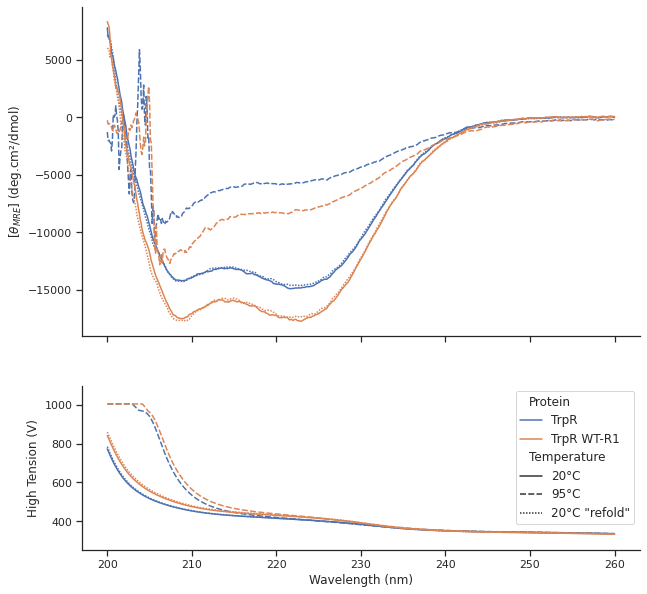

In [3]:
#@title Plot the graph { vertical-output: true }

tab_list = list(accordion.children)
blank_fpath = tab_list.pop(0).value

fpath_lists = [[combobox.value for combobox in tab.children] for tab in tab_list]

# Make DataFrame
df_all = pd.DataFrame()
df_blank = df_cd(blank_fpath)

#@markdown **Protein massic concentration** in mg/mL (usually 0.2 mg/mL):
mass_concentration = 0.2 #@param {type:"number"}

#@markdown **Cell pathlength** in cm (usually 0.2 or 0.1 cm):
cell_pathlength = 0.2 #@param {type:"number"}

for fpath_list, label, mw, reslen in zip(fpath_lists, label_list, mw_list, reslen_list):
    for fpath, temp in zip(fpath_list, temp_list):
        df = df_cd(Path(fpath), df_blank, mw, reslen)
        df['Protein'] = label
        df['Temperature'] = temp
        df_all = df_all.append(df, ignore_index=True)

# Show only signal inferior to a high tension (in V)
#@markdown Show signal only when the **high tension (in V) is inferior to**:… (0 to show whole spectra)
high_tension_cut =  0#@param {type:"number"}
if high_tension_cut:
    df_all = df_all[df_all['HT (V)'] < high_tension_cut]

# Make plot

# Plot parameters
sns.set_theme(style='ticks')
#sns.set_context('talk')

plt.rcParams['savefig.dpi'] = 75
plt.rcParams['text.latex.preamble'] = r'\usepackage{subdepth} \usepackage{amsmath}'
plt.rcParams['figure.autolayout'] = False
#plt.rcParams['figure.figsize'] = 10, 6
#plt.rcParams['axes.labelsize'] = 16
#plt.rcParams['axes.titlesize'] = 16
#plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 3

fig, ax = plt.subplots(2, figsize=(10, 10), sharex=True,
                      gridspec_kw={'height_ratios': [2, 1]})

# Plot CD
params = dict(x='Wavelength (nm)', data=df_all, hue='Protein', style='Temperature')
sns.lineplot(**params, y='θ_MRE (deg.cm²/dmol)', ax=ax[0], legend=False)
ax[0].set_ylabel('[$θ_{MRE}$] (deg.cm²/dmol)') # Mean residue molar ellipticity

# Plot High Tension
sns.lineplot(**params, y='HT (V)', ax=ax[1])
ax[1].set_ylim(bottom=250, top=1100)
ax[1].set_ylabel('High Tension (V)')

sns.despine()

In [4]:
#@title Download graph
format = 'pdf' #@param ['emf', 'eps', 'pdf', 'png', 'ps', 'raw', 'rgba', 'svg', 'svgz']
fn = f'cd.{format}'
fig.savefig(fn)
files.download(fn)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Method

Uploaded txt files should contain averaged values (automatically done by Jasco J-710).
The averaged baseline (only buffer) is substracted from the averaged sample as recommended in [Miles et al. 2021](https://doi.org/10.1039/d0cs00558d).

The mean residue molar ellipticity is then obtained as described in [Kordes et al. 2021](https://doi.org/10.1002/PRO.4249): $[θ_{MRE}] = M·θ / (10·d·c)$ and $M = MW/n - 1$, where $M$ is the mean residue weight, $MW$ the molecular weight in Da, $n$ the number of residues in the protein, $θ$ the averaged collected ellipticity in mdeg, $d$ the path length in mm, and $c$ the protein concentration in mg.ml⁻¹.

# Coding

Feel free to modify the code until the graphs are as beautiful as wished.

If you can spare some time and encounter a bug of any kind or wish for some additions/improvements, please write an issue on the GitHub page. If you code the improvement yourself: please fork the project, modify it and make a Pull request 😉